In [1]:
#%load_ext autoreload
#%autoreload 2
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import emcee
import batman
import corner

import OoT.oot as oot
import scipy.misc as sMisc
from astropy.stats import LombScargle
import astropy.io
import pylanet.data as pydata
import pylanet.model as pymodel
import pylanet.plot as pyplot
import astropy.units as u

%matplotlib inline

In [2]:
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.size']=16
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 3.6
mpl.rcParams['ytick.major.size'] = 3.6
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'

In [3]:
kep2=pydata.getData(2.01,'./data/',cadence='long')
kep13=pydata.getData(13.01,'./data/',cadence='long')

Target: KIC 10666592.
67 data files.
cadence is long
period is 2.204735417
Target: KIC 9941662.
56 data files.
cadence is long
period is 1.763587535


# Kepler-2b, aka HAT-P-7b. Has transits, secondary eclipses, and RVs.

In [4]:
rawTs=kep2.times
rawFs=kep2.sap_fluxs
rawEs=kep2.sap_flux_errs
period=kep2.period

In [5]:
#detrend
cTs,cFs,cEs=pydata.cleanData(rawTs,rawFs,rawEs,kep2.period,nMin=512,detrendMethod='box')
print(cTs.size,' data points')

56109  data points


In [6]:
#phase-fold
ts,fs,es=pydata.stackData(cTs,cFs,cEs,period,nTs=128)

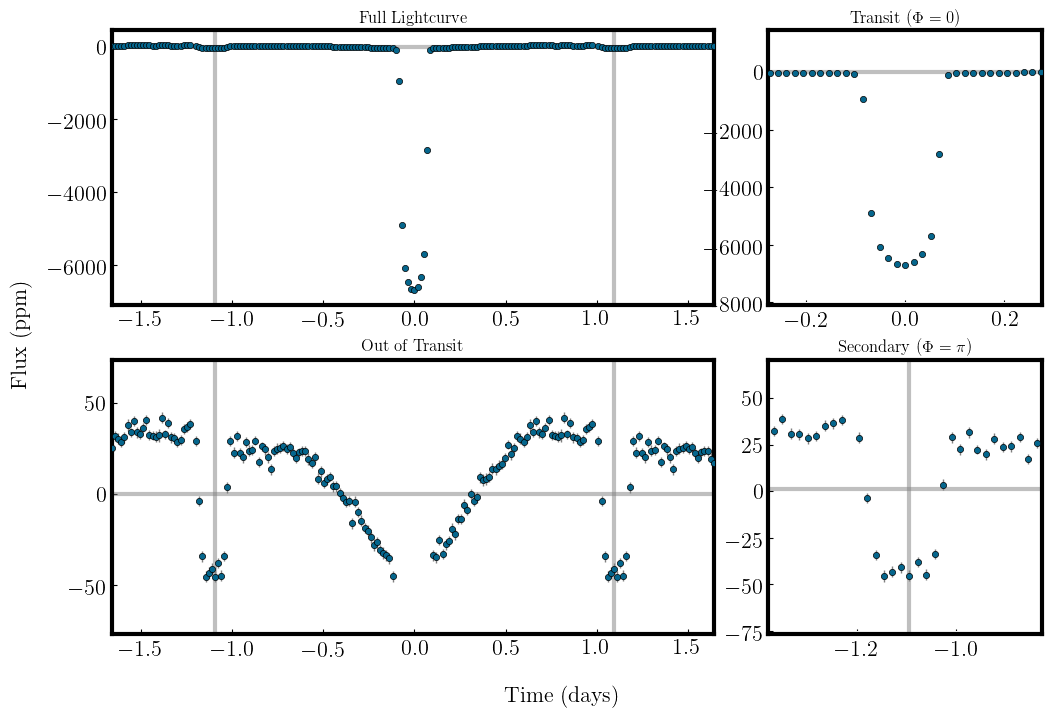

In [7]:
#plot
thisFig,thisGrid=pyplot.makeFig()
pyplot.plotData(thisGrid,ts,fs,es,period=period)

In [8]:
#Create OoT planet object and assign parameters according to NEA values.
planet=oot.planet()
planet.M=1.56
planet.R=2.0
planet.Mp=0.002
planet.Rp=0.155

planet.e=0.006
planet.Ag=0.2
planet.a=planet.a*np.power(period/oot.findPeriod(planet),2./3.)
print('a: ',planet.a)
tTransit=0.
planet.vPhi=np.pi/2. - (np.pi/180.)*204.
planet.vTheta=83.*np.pi/180.
planet.tp=planet.tp+(tTransit-oot.findTransit(planet))

nTs=600
modelTs=np.linspace(-period/2.,period/2.,nTs)
modelFs=1+oot.deltaSum(modelTs,planet)

transit=1
if transit==1:
    t0,per,rp,a,inc,ecc,w=oot.batman(planet)
    params = batman.TransitParams()
    params.t0 = t0                       #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                     #planet radius (in units of stellar radii)
    params.a = a                       #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = ecc                      #eccentricity
    params.w = w                       #longitude of periastron (in degrees)
    params.u = [0.6]                #limb darkening coefficients
    params.limb_dark = "linear"       #limb darkening model

    m = batman.TransitModel(params, modelTs)
    batmanModel=m.light_curve(params)
    modelFs=modelFs*batmanModel

norm=np.median(modelFs)
modelFs=(modelFs/norm)-1 + 1.2e-05 #add flux offset to make them line up better
#fs=deltas-np.max(deltas)
modelEs=0.1*np.ones_like(modelFs)*np.median(np.abs(modelFs))


a:  8.271231707463656


/Users/Emily/Documents/Columbia/heartbeatPlanets/OoT/oot.py:142: RuntimeWarning: invalid value encountered in arccos
  firstTerm=((rUnit*pl.Rp)**2)*np.arccos((d**2 + (rUnit*pl.Rp)**2 - pl.R**2)/(2*d*(rUnit*pl.Rp)))
/Users/Emily/Documents/Columbia/heartbeatPlanets/OoT/oot.py:143: RuntimeWarning: invalid value encountered in arccos
  secondTerm=(pl.R**2)*np.arccos((d**2 + pl.R**2 - (rUnit*pl.Rp)**2)/(2*d*pl.R))
/Users/Emily/Documents/Columbia/heartbeatPlanets/OoT/oot.py:144: RuntimeWarning: invalid value encountered in sqrt
  thirdTerm=-0.5*np.sqrt((d+(rUnit*pl.Rp)+pl.R)*(d+(rUnit*pl.Rp)-pl.R)*(d+pl.R-(rUnit*pl.Rp))*(-d+pl.R+(rUnit*pl.Rp)))


/Users/Emily/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


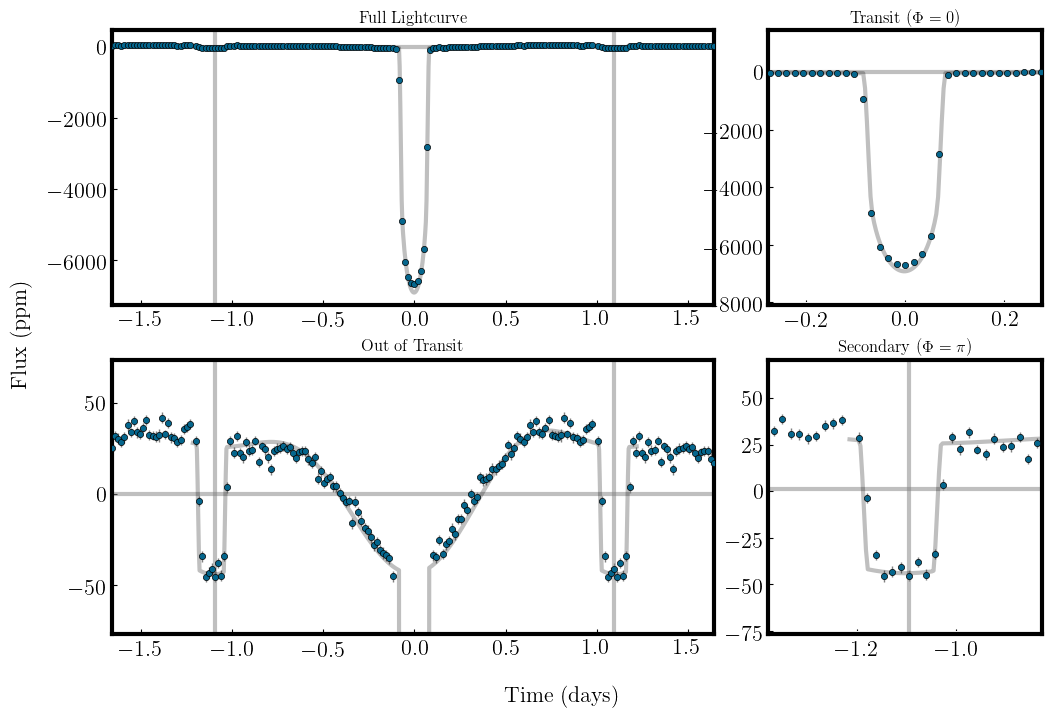

In [9]:
thisFig,thisGrid=pyplot.makeFig()
pyplot.plotData(thisGrid,ts,fs,es,period=period)
pyplot.plotModel(thisGrid,modelTs,modelFs,period=period)

In [10]:
from scipy.stats import norm,beta,truncnorm
def transform_uniform(x,a,b):
    return a + (b-a)*x

def transform_loguniform(x,a,b):
    la=np.log(a)
    lb=np.log(b)
    return np.exp(la + x*(lb-la))

def transform_normal(x,mu,sigma):
    return norm.ppf(x,loc=mu,scale=sigma)

def transform_beta(x,a,b):
    return beta.ppf(x,a,b)

def transform_truncated_normal(x,mu,sigma,a=0.,b=1.):
    ar, br = (a - mu) / sigma, (b - mu) / sigma
    return truncnorm.ppf(x,ar,br,loc=mu,scale=sigma)


## Fit light curve alone

In [15]:
# "walking" parameters:
#    0 = np.log10(Mstar [Msun])
#    1 = np.log10(Mplanet [Msun])
#    2 = np.log10(Rstar [Rsun])
#    3 = np.log10(Rplanet [Rsun])
#    4 = np.log10(ecc)
#    5 = Ag
#    6 = t0 [transit midpoint time, centered at 0 days]
#    7 = b
#    8 = vPhi = pi/2 - omega
#    9 = fractional flux offset

# convert "walking" params to OoT params
def translateParams(planet,x):
    planet.M=10**x[0]
    planet.Mp=10**x[1]
    planet.R=10**x[2]
    planet.Rp=10**x[3]
    planet.e=10**x[4]
    planet.Ag=x[5]
    tTransit=x[6]
    #planet.tp=tTransit-oot.findTransit(planet)
    planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3) # For a known period, a is a dependant variable
    
    b=x[7]
    planet.vTheta=np.arccos(b*planet.R/planet.a)
    planet.vPhi=x[8]
    
    planet.tp=planet.tp+(tTransit-oot.findTransit(planet))
    
    return planet

def mapXs(x, period): 
    """
    maps 0->1 to appropriate parameter values
    """
    newX=np.copy(x)
    if len(newX.shape)==1:
        newX=newX[np.newaxis,:]
        
    newX[:,0] = transform_uniform(newX[:,0], -1., 1.)       #log10(Mstar)
    newX[:,1] = transform_uniform(newX[:,1], -3.5, -0.5)    #log10(Mplanet)
    newX[:,2] = transform_uniform(newX[:,2], -1.5, 1.5)     #log10(Rstar)
    newX[:,3] = transform_uniform(newX[:,3], -2., 0.)       #log10(Rplanet)
    newX[:,4] = transform_uniform(newX[:,4], -3., 0.)       #log10(ecc)
    newX[:,5] = transform_uniform(newX[:,5], 0., 0.5)       #Ag
    newX[:,6] = transform_uniform(newX[:,6], -0.5*period, 0.5*period)  #t0, centered at 0 days
    #newX[:,7] = transform_uniform(newX[:,7], 0., 1.)       #impact parameter b, no transformation necessary
    newX[:,8] = transform_uniform(newX[:,8], 0., 2.*np.pi)  #vPhi
    newX[:,9] = transform_uniform(newX[:,9], -1.e-4, 1.e-4) #flux offset
    
    if len(x.shape)==1:
        return newX[0,:]
    return newX

def priors(x):
    """
    if we wander outside the unit cube, return -np.inf
    """
    if (np.min(x)<0.) | (np.max(x)>1.):
        return -np.inf
    else:
        return 0.0
    
def lnprobLC(x,period,ts,fs,es,planet):
    """The log-likelihood function."""
    
    prior=priors(x) # ensure all x between 0 and 1
    if not np.isfinite(prior):
        return prior
    
    x=mapXs(x,period) # maps them to appropriate parameter values
    planet=translateParams(planet,x)
    if (planet.R<planet.Rp) | (planet.R>planet.a):
        return -np.inf #at the moment oot breaks if R<Rp - should investigate
    
    ootFs=1.+oot.deltaSum(ts,planet,secondary=1)
    
    transit=oot.checkTransit(planet)
    if transit==1:
        t0,per,rp,a,inc,ecc,w=oot.batman(planet)
        params = batman.TransitParams()
        params.t0 = t0                       #time of inferior conjunction
        params.per = per                      #orbital period
        params.rp = rp                     #planet radius (in units of stellar radii)
        params.a = a                       #semi-major axis (in units of stellar radii)
        params.inc = inc                     #orbital inclination (in degrees)
        params.ecc = ecc                      #eccentricity
        params.w = w                       #longitude of periastron (in degrees)
        params.u = [0.6]                #limb darkening coefficients
        params.limb_dark = "linear"       #limb darkening model

        m = batman.TransitModel(params, ts)
        batmanModel=m.light_curve(params)
        modelFs=ootFs*batmanModel
    else:
        modelFs=ootFs
    
    norm=np.median(modelFs)
    deltas=(modelFs/norm)-1
    deltas=deltas+x[9]     #add fractional flux offset term
    
    residual=np.power((deltas-fs)/es,2)
    return -0.5*np.sum(residual)/2 + prior

ndim, nwalkers = 10, 128
p0=np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

nSteps = 2048
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobLC,args=[period,ts,fs,es,planet])
pos, prob, state=sampler.run_mcmc(p0,nSteps)

/Users/Emily/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in arccos


(128, 2048, 10)
(70144, 10)


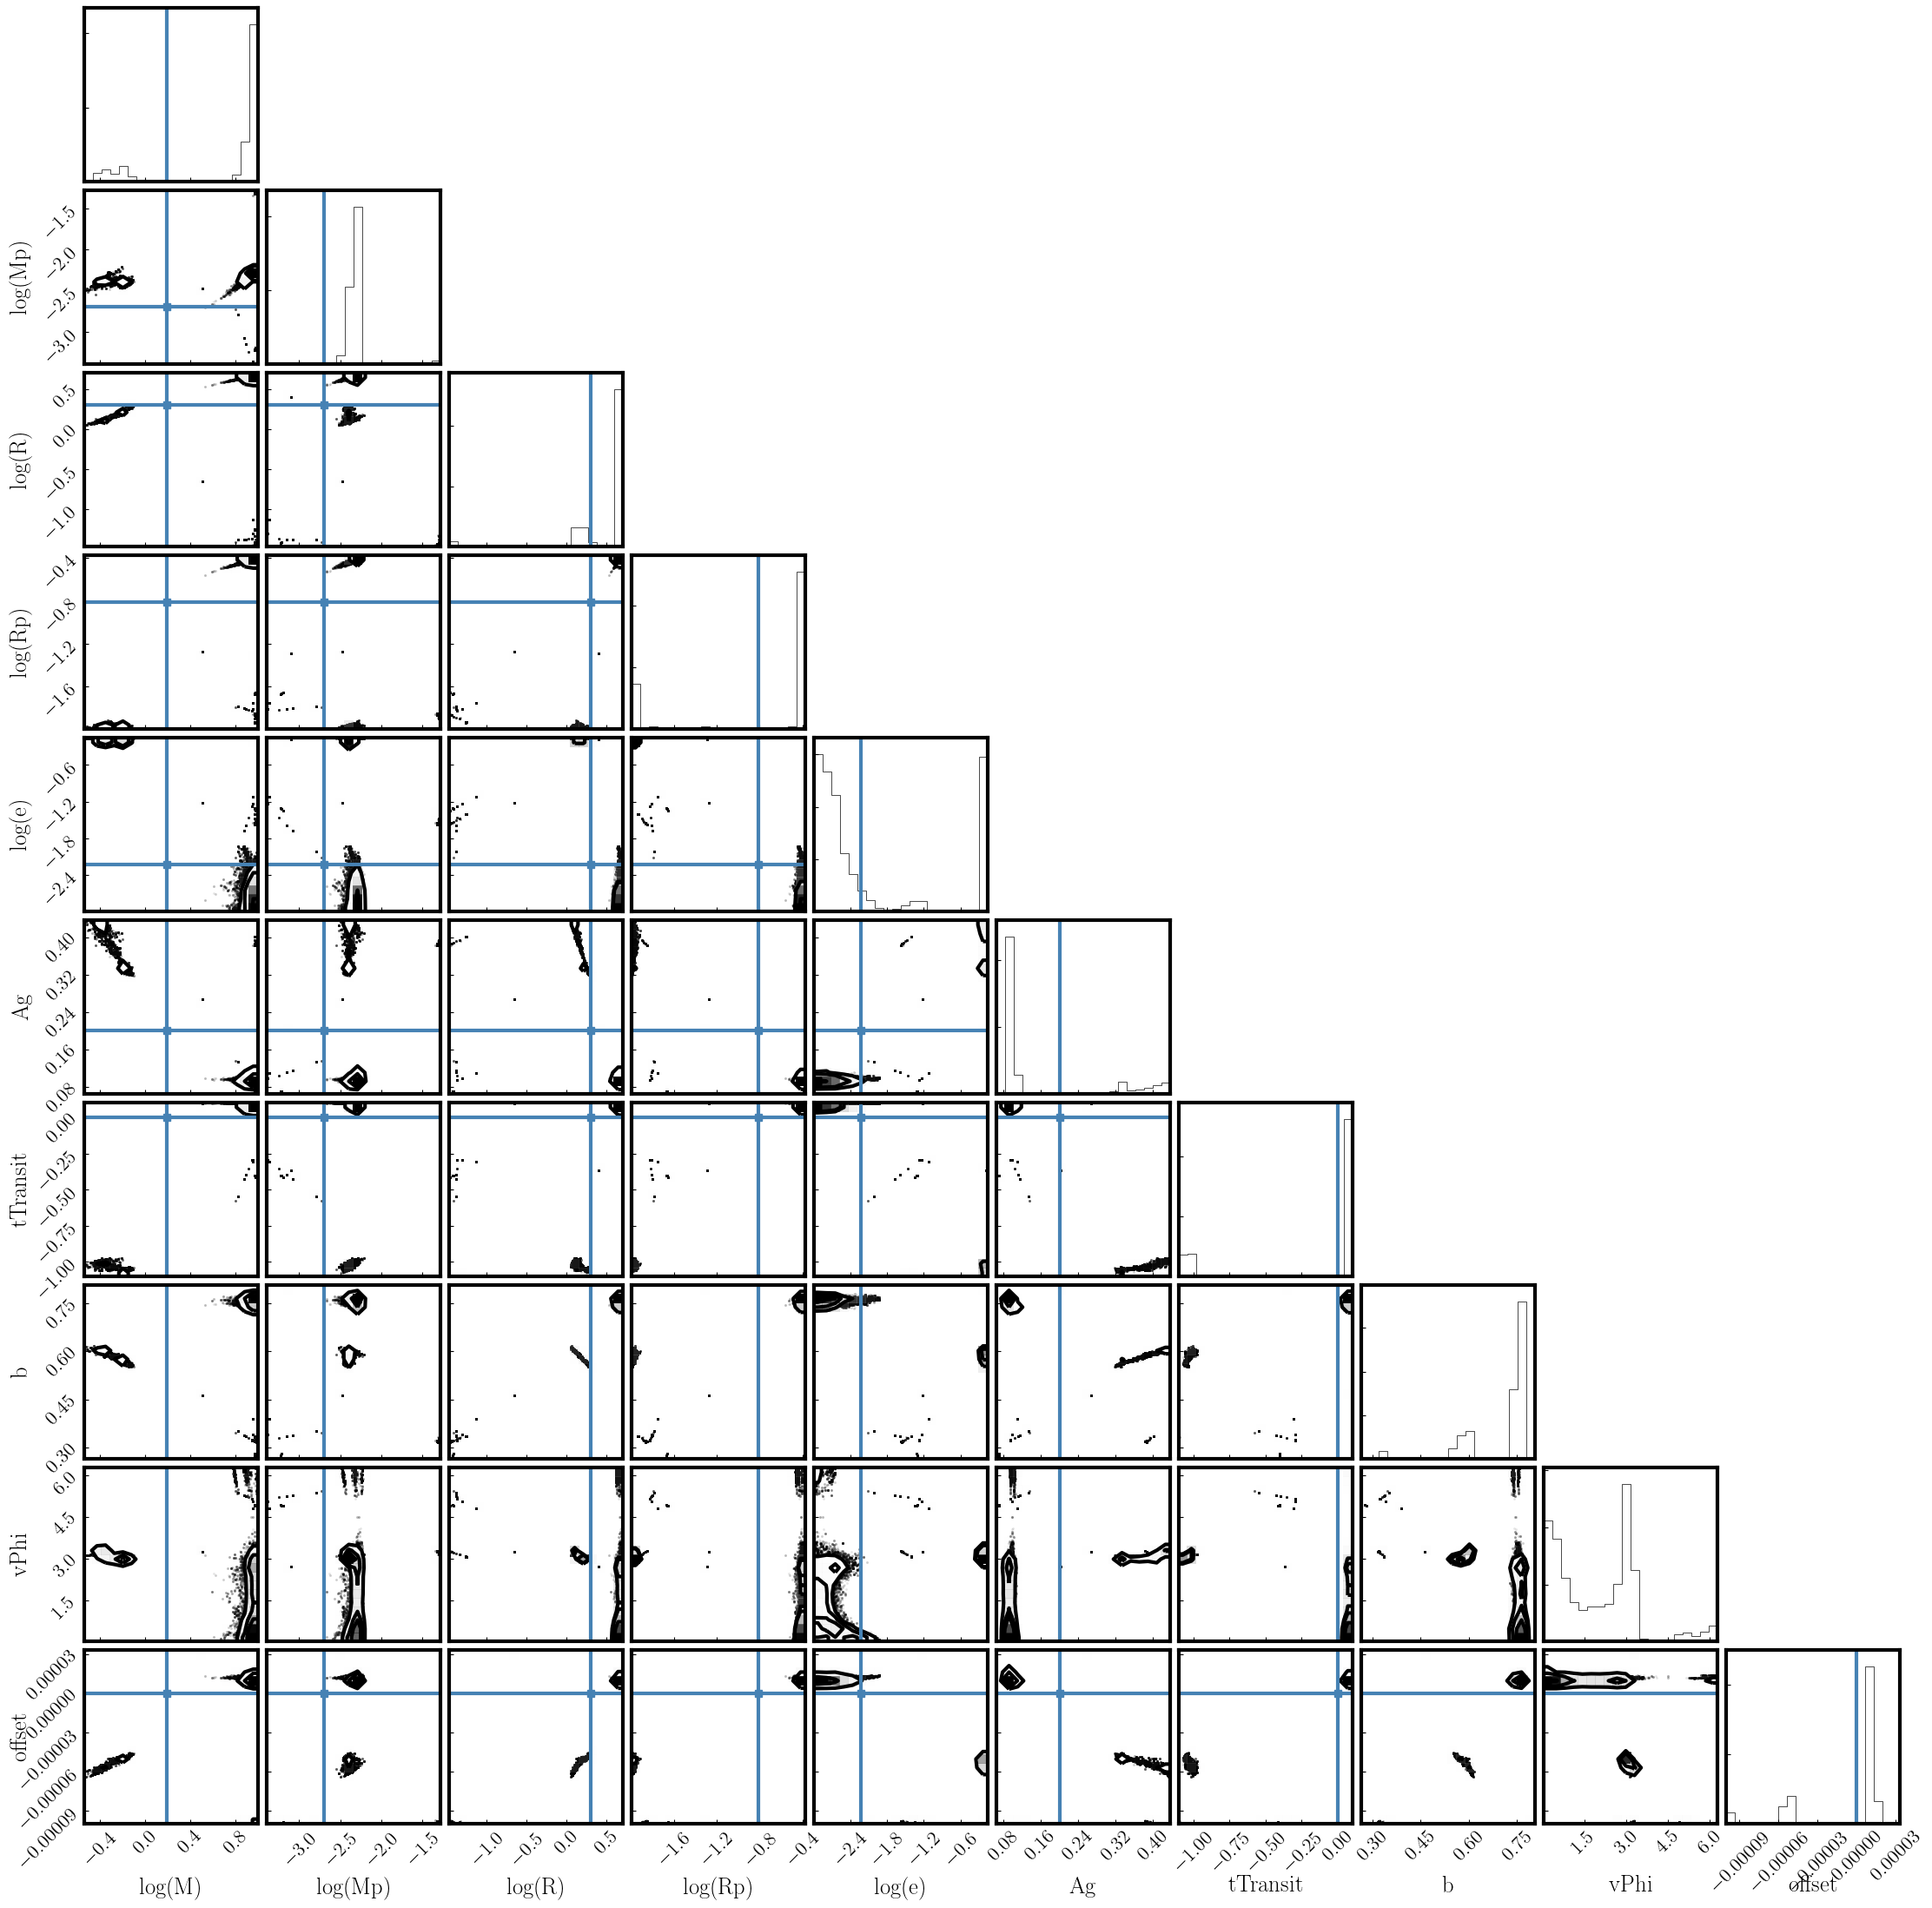

In [22]:
#make corner plot
print(np.shape(sampler.chain))
samples = sampler.chain[:,1500:,:].reshape((-1, ndim))
truths=[np.log10(1.56),np.log10(0.002),np.log10(2.),np.log10(0.155),np.log10(0.006),0.2,0.,0.224,np.pi/2. - (np.pi/180.)*204.,0.]
mapped=mapXs(samples,period)
print(np.shape(mapped))
fig = corner.corner(mapped,labels=['log(M)','log(Mp)','log(R)','log(Rp)','log(e)','Ag','tTransit','b','vPhi','offset'],truths=truths)
plt.show()

[ 9.95796573e-01 -2.27050671e+00  6.95977803e-01 -3.87702551e-01
 -2.53653609e+00  9.63772178e-02  9.85317332e-02  7.64938875e-01
  2.58502960e-01  1.23158708e-05]


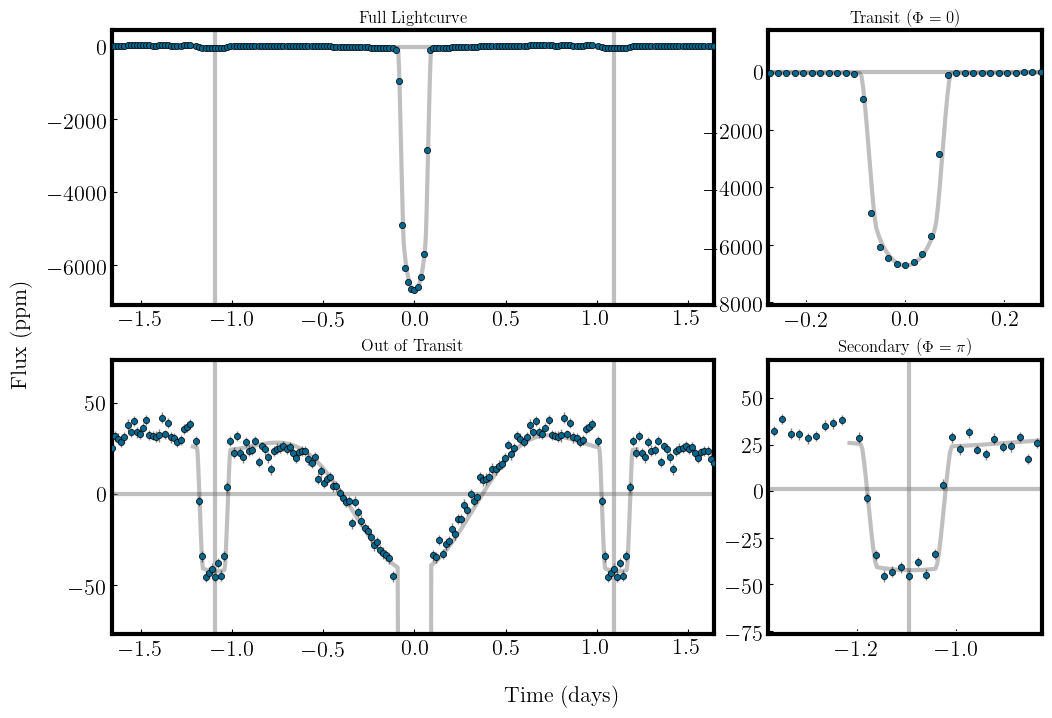

In [23]:
bestX=pos[np.argmax(prob),:]

print(mapXs(bestX, period))

planet=translateParams(planet,mapXs(bestX, period))
planet.a=planet.a*np.power(period/oot.findPeriod(planet),2./3.)

nTs=600
modelTs=np.linspace(-period/2.,period/2.,nTs)
#modelTs=np.hstack([modelTs[:500],modelTs[600:]])
ootFs=1+oot.deltaSum(modelTs,planet)#,secondary=1)

transit=oot.checkTransit(planet)
if transit==1:
    t0,per,rp,a,inc,ecc,w=oot.batman(planet)
    params = batman.TransitParams()
    params.t0 = t0                       #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                     #planet radius (in units of stellar radii)
    params.a = a                       #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = ecc                      #eccentricity
    params.w = w                       #longitude of periastron (in degrees)
    params.u = [0.6]                #limb darkening coefficients
    params.limb_dark = "linear"       #limb darkening model

    m = batman.TransitModel(params, modelTs)
    batmanModel=m.light_curve(params)
    modelFs=ootFs*batmanModel
    norm=np.median(modelFs)
    
deltas=(modelFs/norm)-1
deltas=deltas+mapXs(bestX, period)[9]

# plot maximum a posteriori model
thisFig,thisGrid=pyplot.makeFig()
pyplot.plotData(thisGrid,ts,fs,es,period=kep2.period)
pyplot.plotModel(thisGrid,modelTs,deltas,period=kep2.period)
plt.show()

#### Check chain convergence

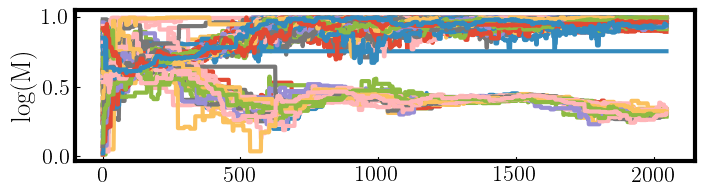

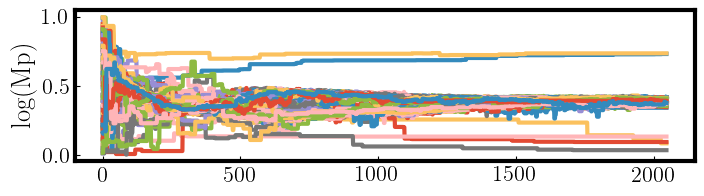

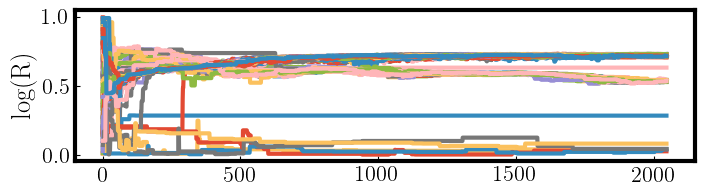

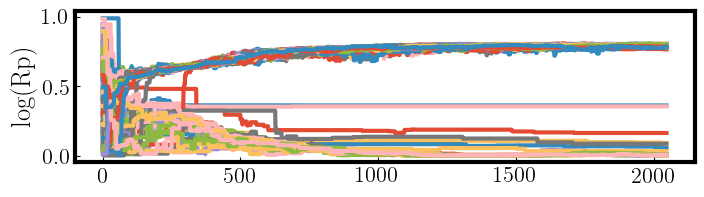

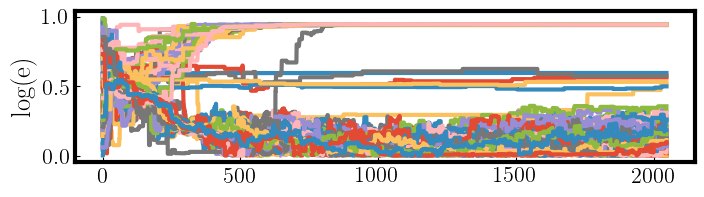

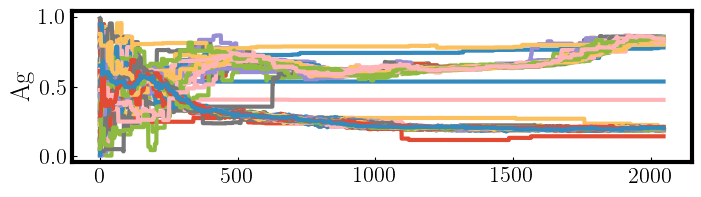

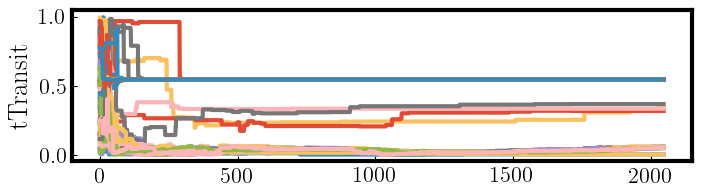

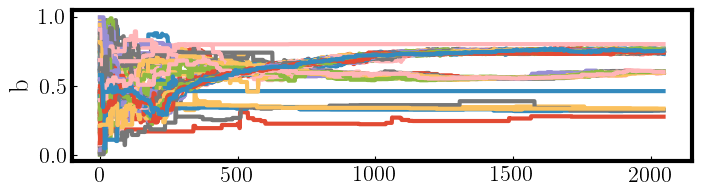

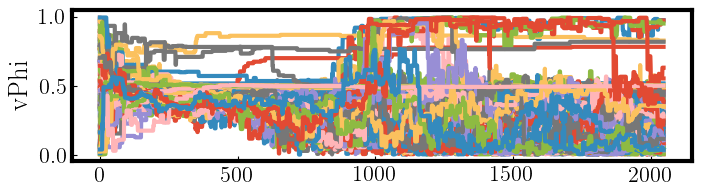

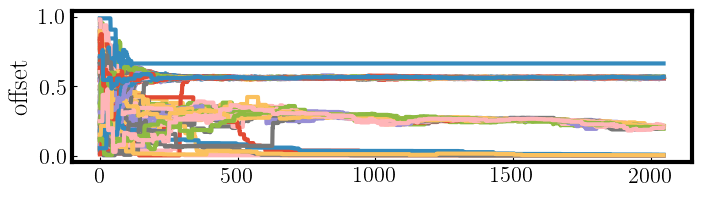

In [24]:
labels=['log(M)','log(Mp)','log(R)','log(Rp)','log(e)','Ag','tTransit','b','vPhi','offset']

for i in range(10):
    fig = plt.figure(figsize=(8,2))
    for j in range(nwalkers):
        plt.plot(sampler.chain[j,:,i])
    
    plt.ylabel(labels[i])
    plt.show()

## Try fitting RVs separately

a:  8.271231707463656
51
32


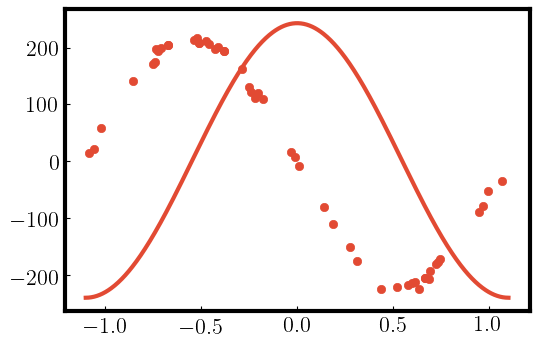

In [25]:
planet=oot.planet()
planet.M=1.56
planet.R=2.0
planet.Mp=0.002
planet.Rp=0.155

planet.e=0.006
planet.Ag=0.2
planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3)
print('a: ',planet.a)
tTransit=0
planet.vPhi=0.5*np.pi
planet.vTheta=83*np.pi/180

#load in RV data
data=astropy.io.ascii.read('hat-p-7b.csv')
rTs=data['x']*period # in days
rVs=data['rvs'] # in ms-1
rEs=np.array([5,15,15,15,8,10,15,12,5,5,10,12,10,10,15,15,8,5,5,5,10,12,12,5,5,15,10,8,15,20,5,10])
print(rVs.size)
print(rEs.size)
thisPlot=plt.gca()
thisPlot.scatter(rTs,rVs)
modelRvs=oot.vOrbit(modelTs,planet)#*695508000/(24*60*2)
thisPlot.plot(modelTs,modelRvs)
plt.show()

In [34]:
# "walking" parameters:
#    0 = np.log10(Mstar [Msun])
#    1 = np.log10(Mplanet [Msun])
#    2 = np.log10(Rstar [Rsun])
#    3 = np.log10(ecc)
#    4 = t0 [transit midpoint time, centered at 0 days]
#    5 = b
#    6 = vPhi = pi/2 - omega

def rvParams(planet,x):
    planet.M=10**x[0]
    planet.Mp=10**x[1]
    planet.R=10**x[2]
    planet.e=10**x[3]
    tTransit=x[4]

    #planet.tp=tTransit-oot.findTransit(planet)
    planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3) # For a known period, a is a dependant variable
    
    b=x[5]
    planet.vTheta=np.arccos(b*planet.R/planet.a)
    planet.vPhi=x[6]
    
    planet.tp=planet.tp+(tTransit-oot.findTransit(planet))
    return planet

def mapRvs(x, period): #maps 0->1 to appropriate parameter values
    newX=np.copy(x)
    if len(newX.shape)==1:
        newX=newX[np.newaxis,:]
        
    newX[:,0] = transform_uniform(newX[:,0], -1., 1.)      #log10(Mstar)
    newX[:,1] = transform_uniform(newX[:,1], -3.5, -0.5)   #log10(Mplanet)
    newX[:,2] = transform_uniform(newX[:,2], -1.5, 1.5)    #log10(Rstar)
    newX[:,3] = transform_uniform(newX[:,3], -3., 0.)      #log10(ecc)
    newX[:,4] = transform_uniform(newX[:,4], -0.5*period, 0.5*period) #tTransit
    #newX[:,5] = transform_uniform(newX[:,5], 0., 1.)      #b (no transform necessary)
    newX[:,6] = transform_uniform(newX[:,6], 0., 2.*np.pi) #vPhi

    if len(x.shape)==1:
        return newX[0,:]
    return newX

def priors(x):
    if (np.min(x)<0) | (np.max(x)>1):
        return -np.inf
    else:
        return 0.0
    
def rvprob(x,period,ts,rvs,rEs,planet):
    """The log-likelihood function."""
    prior=priors(x) # all x between 0 and 1
    if prior<0:
        return prior
    x=mapRvs(x, period) # maps them to appropriate parameter values
    planet=rvParams(planet,x)
    if (planet.R>planet.a):
        return -np.inf #at the moment oot breaks if R<Rp - should investigate
    
    ootRvs=oot.vSum(ts,planet)
    
    residual=np.power((ootRvs-rvs)/rEs,2)
    return -(np.sum(residual)/2) + prior

ndim, nwalkers = 7, 64
p0=np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

nSteps = 256
sampler = emcee.EnsembleSampler(nwalkers, ndim, rvprob,args=[period,rTs,rVs,10*np.ones_like(rVs),planet])
pos, prob, state=sampler.run_mcmc(p0,nSteps)

/Users/Emily/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in arccos


(64, 256, 7)


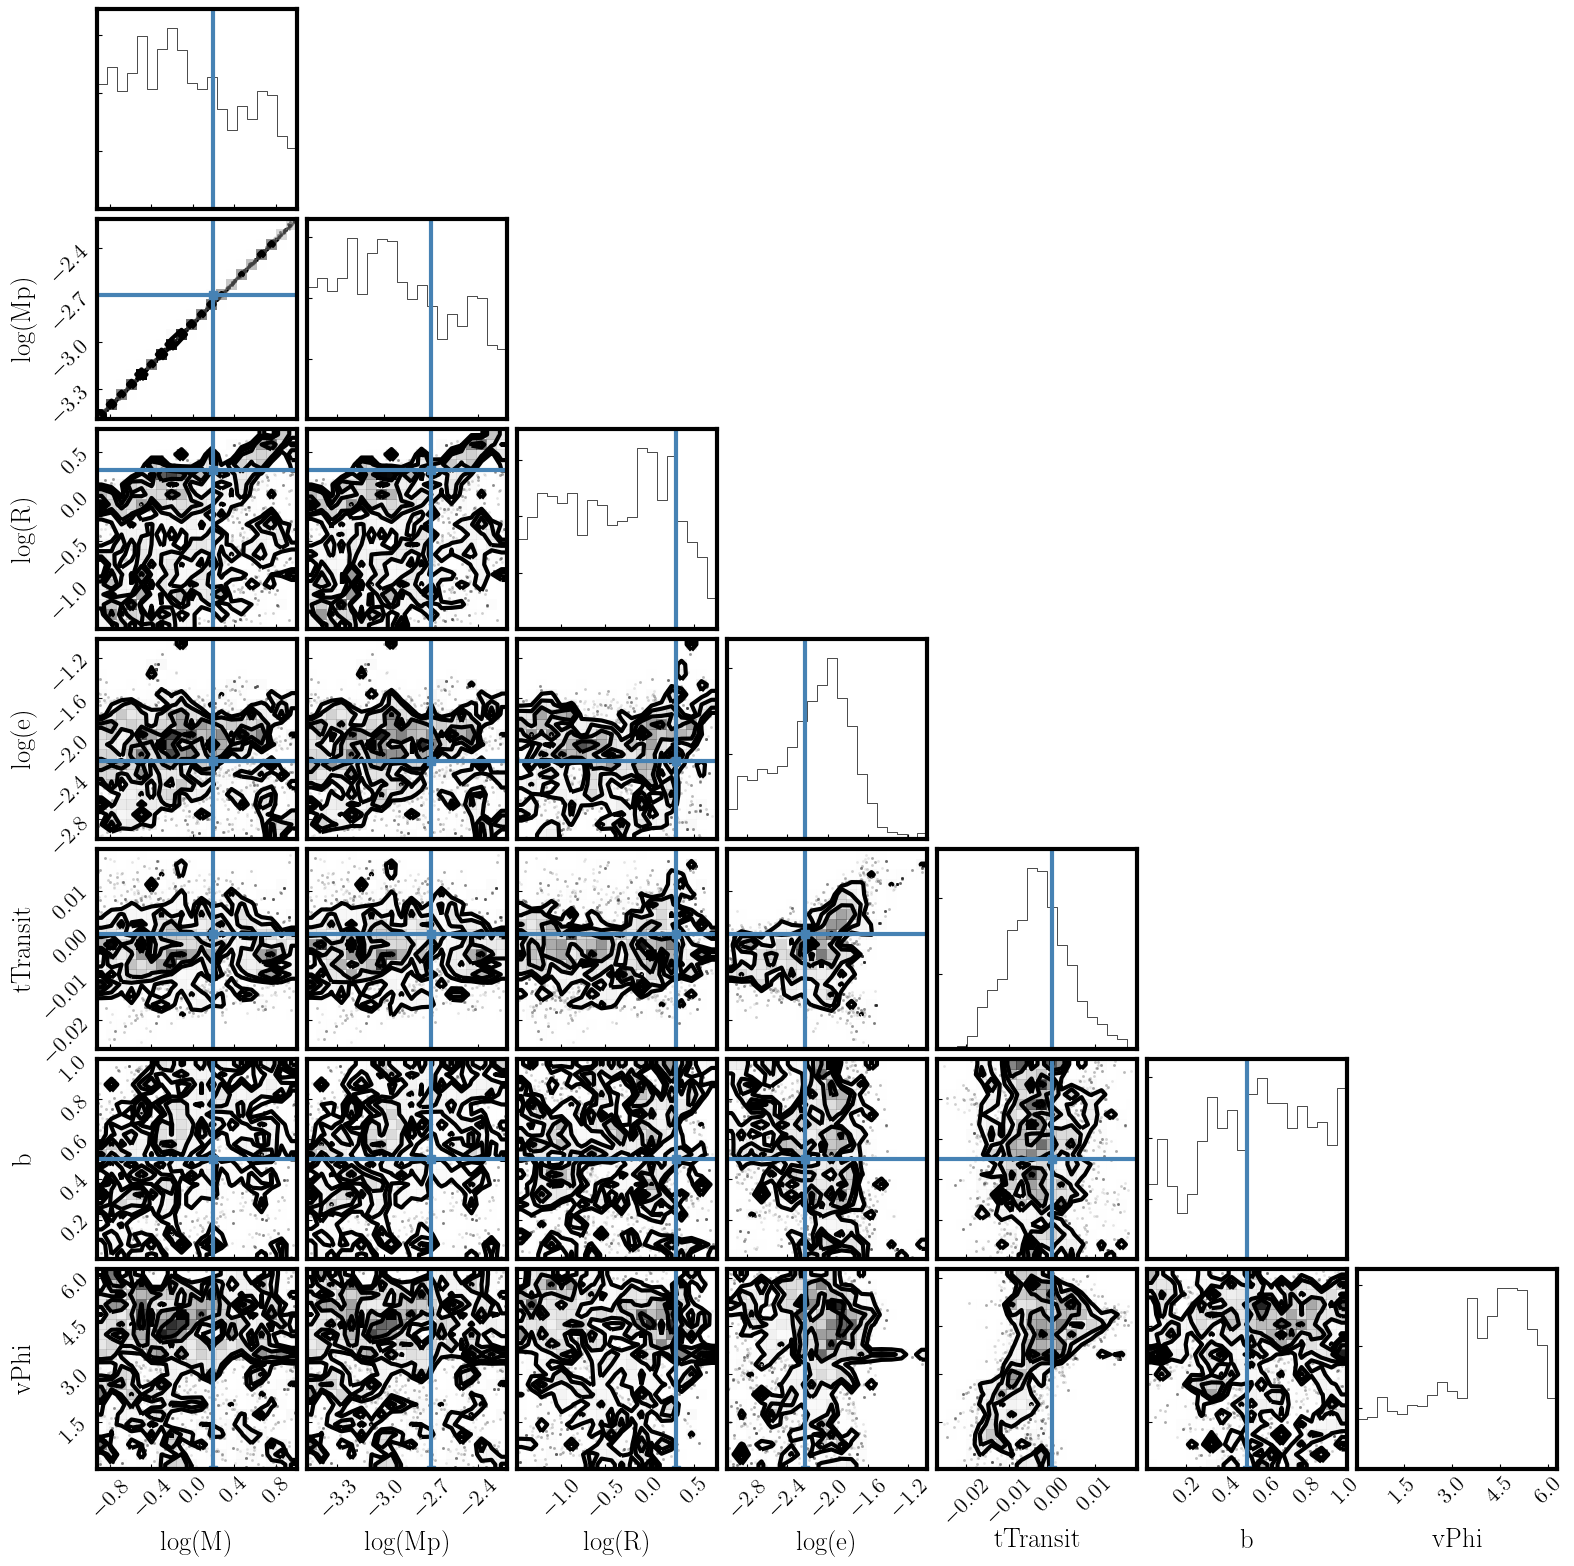

In [38]:
print(np.shape(sampler.chain))
samples = sampler.chain[:,125:,:].reshape((-1, ndim))
truths=[np.log10(1.56),np.log10(0.002),np.log10(2),np.log10(0.006),0,0.5,0,0]
mapped=mapRvs(samples, period)
fig = corner.corner(mapped,labels=['log(M)','log(Mp)','log(R)','log(e)','tTransit','b','vPhi','offset'],truths=truths)
plt.show()

[ 6.21612116e-01 -2.45655182e+00  6.54634915e-01 -1.48562466e+00
  2.59599245e-03  3.74534357e-01  3.48092533e+00]


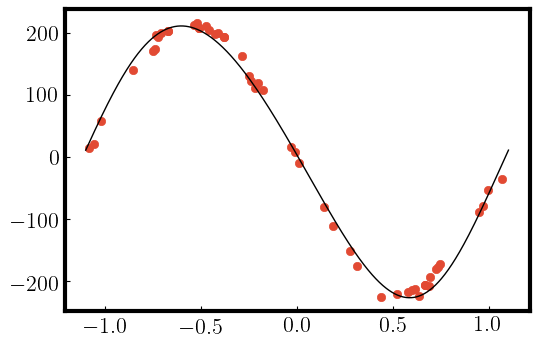

In [39]:
bestX=pos[np.argmax(prob),:]
print(mapRvs(bestX, period))
planet=rvParams(planet,mapRvs(bestX, period))
planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3)
planet.e=0.1
nTs=600
modelTs=np.linspace(-period/2,period/2,nTs)

thisPlot=plt.gca()
thisPlot.scatter(rTs,rVs)
modelRvs=oot.vSum(modelTs,planet)#*695508000/(24*60*2)
thisPlot.plot(modelTs,modelRvs,c='k',lw=1)
plt.show()

#### Check chain convergence

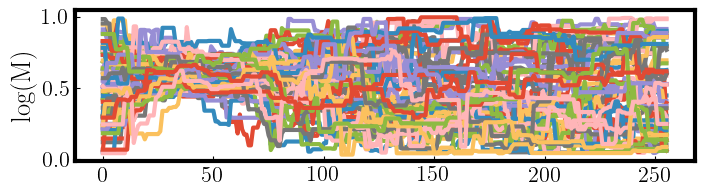

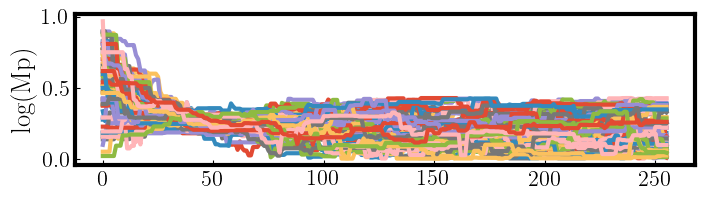

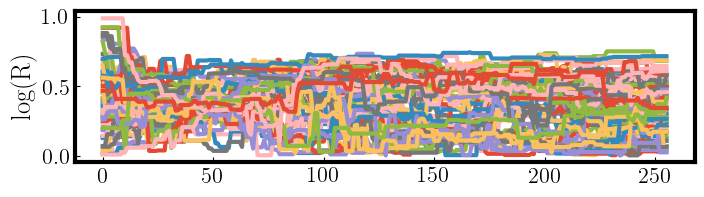

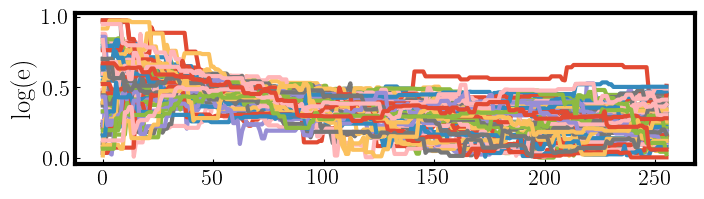

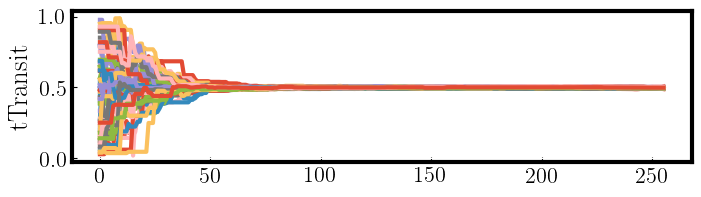

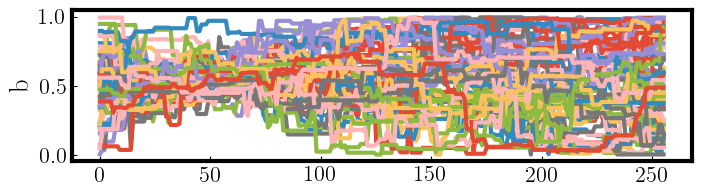

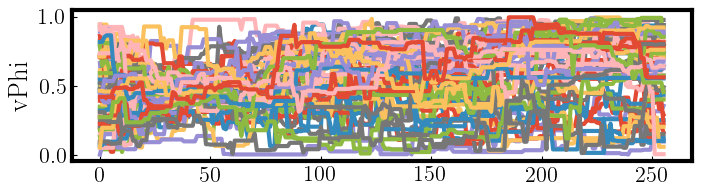

In [40]:
labels=['log(M)','log(Mp)','log(R)','log(e)','tTransit','b','vPhi','offset']

for i in range(7):
    fig = plt.figure(figsize=(8,2))
    for j in range(nwalkers):
        plt.plot(sampler.chain[j,:,i])
    
    plt.ylabel(labels[i])
    plt.show()

## Fit LC and RVs simultaneously

In [63]:
# "walking" parameters:
#    0 = np.log10(Mstar [Msun])
#    1 = np.log10(Mplanet [Msun])
#    2 = np.log10(Rstar [Rsun])
#    3 = np.log10(Rplanet [Rsun])
#    4 = np.log10(ecc)
#    5 = Ag
#    6 = t0 [transit midpoint time, centered at 0 days]
#    7 = b
#    8 = vPhi = pi/2 - omega
#    9 = fractional flux offset
#   10 = RV time offset

def translateParams(planet,x):
    planet.M=10**x[0]
    planet.Mp=10**x[1]
    planet.R=10**x[2]
    planet.Rp=10**x[3]
    planet.e=10**x[4]
    planet.Ag=x[5]
    tTransit=x[6]

    #planet.tp=tTransit-oot.findTransit(planet)
    planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3) # For a known period, a is a dependant variable
    #print(planet.a)
    
    b=x[7]
    planet.vTheta=np.arccos(b*planet.R/planet.a)
    planet.vPhi=x[8]
    
    planet.tp=planet.tp+(tTransit-oot.findTransit(planet))
    
    return planet

def mapXs(x, period): #maps 0->1 to appropriate parameter values
    newX=np.copy(x)
    if len(newX.shape)==1:
        newX=newX[np.newaxis,:]
        
        
    newX[:,0] = transform_uniform(newX[:,0], -1., 3.)       #log10(Mstar)
    newX[:,1] = transform_uniform(newX[:,1], -3.5, -0.5)    #log10(Mplanet)
    newX[:,2] = transform_uniform(newX[:,2], -1.5, 1.5)     #log10(Rstar)
    newX[:,3] = transform_uniform(newX[:,3], -2., 0.)       #log10(Rplanet)
    newX[:,4] = transform_uniform(newX[:,4], -3., 0.)       #log10(ecc)
    newX[:,5] = transform_uniform(newX[:,5], 0., 0.5)       #Ag
    newX[:,6] = transform_uniform(newX[:,6], -0.5*period, 0.5*period)  #t0, centered at 0 days
    #newX[:,7] = transform_uniform(newX[:,7], 0., 1.)       #impact parameter b, no transformation necessary
    newX[:,8] = transform_uniform(newX[:,8], 0., 2.*np.pi)  #vPhi
    newX[:,9] = transform_uniform(newX[:,9], -1.e-4, 1.e-4) #flux offset
    newX[:,10] = transform_uniform(newX[:,10], -0.5*period, 0.5*period) #RV time offset
    
    if len(x.shape)==1:
        return newX[0,:]
    return newX

def priors(x):
    if (np.min(x)<0) | (np.max(x)>1):
        return -np.inf
    else:
        return 0.0
    
def lnprob(x,period,ts,fs,es,rTs,rVs,rEs,planet):
    """The log-likelihood function."""
    prior=priors(x) # all x between 0 and 1
    if prior<0:
        return prior
    x=mapXs(x,period) # maps them to appropriate parameter values
    planet=translateParams(planet,x)
    if (planet.R<planet.Rp) | (planet.R>planet.a):
        return -np.inf #at the moment oot breaks if R<Rp - should investigate
    
    ootFs=1+oot.deltaSum(ts,planet,secondary=1)
    
    transit=oot.checkTransit(planet)
    if transit==1:
        t0,per,rp,a,inc,ecc,w=oot.batman(planet)
        params = batman.TransitParams()
        params.t0 = t0                       #time of inferior conjunction
        params.per = per                      #orbital period
        params.rp = rp                     #planet radius (in units of stellar radii)
        params.a = a                       #semi-major axis (in units of stellar radii)
        params.inc = inc                     #orbital inclination (in degrees)
        params.ecc = ecc                      #eccentricity
        params.w = w                       #longitude of periastron (in degrees)
        params.u = [0.6]                #limb darkening coefficients
        params.limb_dark = "linear"       #limb darkening model

        m = batman.TransitModel(params, ts)
        batmanModel=m.light_curve(params)
        modelFs=ootFs*batmanModel
    else:
        modelFs=ootFs
    
    norm=np.median(modelFs)
    deltas=(modelFs/norm)-1
    deltas=deltas+x[9]
    #deltas=deltas-np.max(deltas)
    
    residual=np.power((deltas-fs)/es,2)
    
    rvTs=((rTs+x[10])%period)-(period/2)
    ootRvs=oot.vSum(rvTs,planet)
    rvResidual=np.power((ootRvs-rVs)/rEs,2)
    
    return -(np.sum(residual)/2) -(np.sum(rvResidual)/2) + prior

ndim, nwalkers = 11, 64
p0=np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

nSteps = 2048
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,args=[period,ts,fs,es,rTs,rVs,5*np.ones_like(rVs),planet])
pos, prob, state=sampler.run_mcmc(p0,nSteps)

/Users/Emily/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in arccos


(64, 2048, 11)


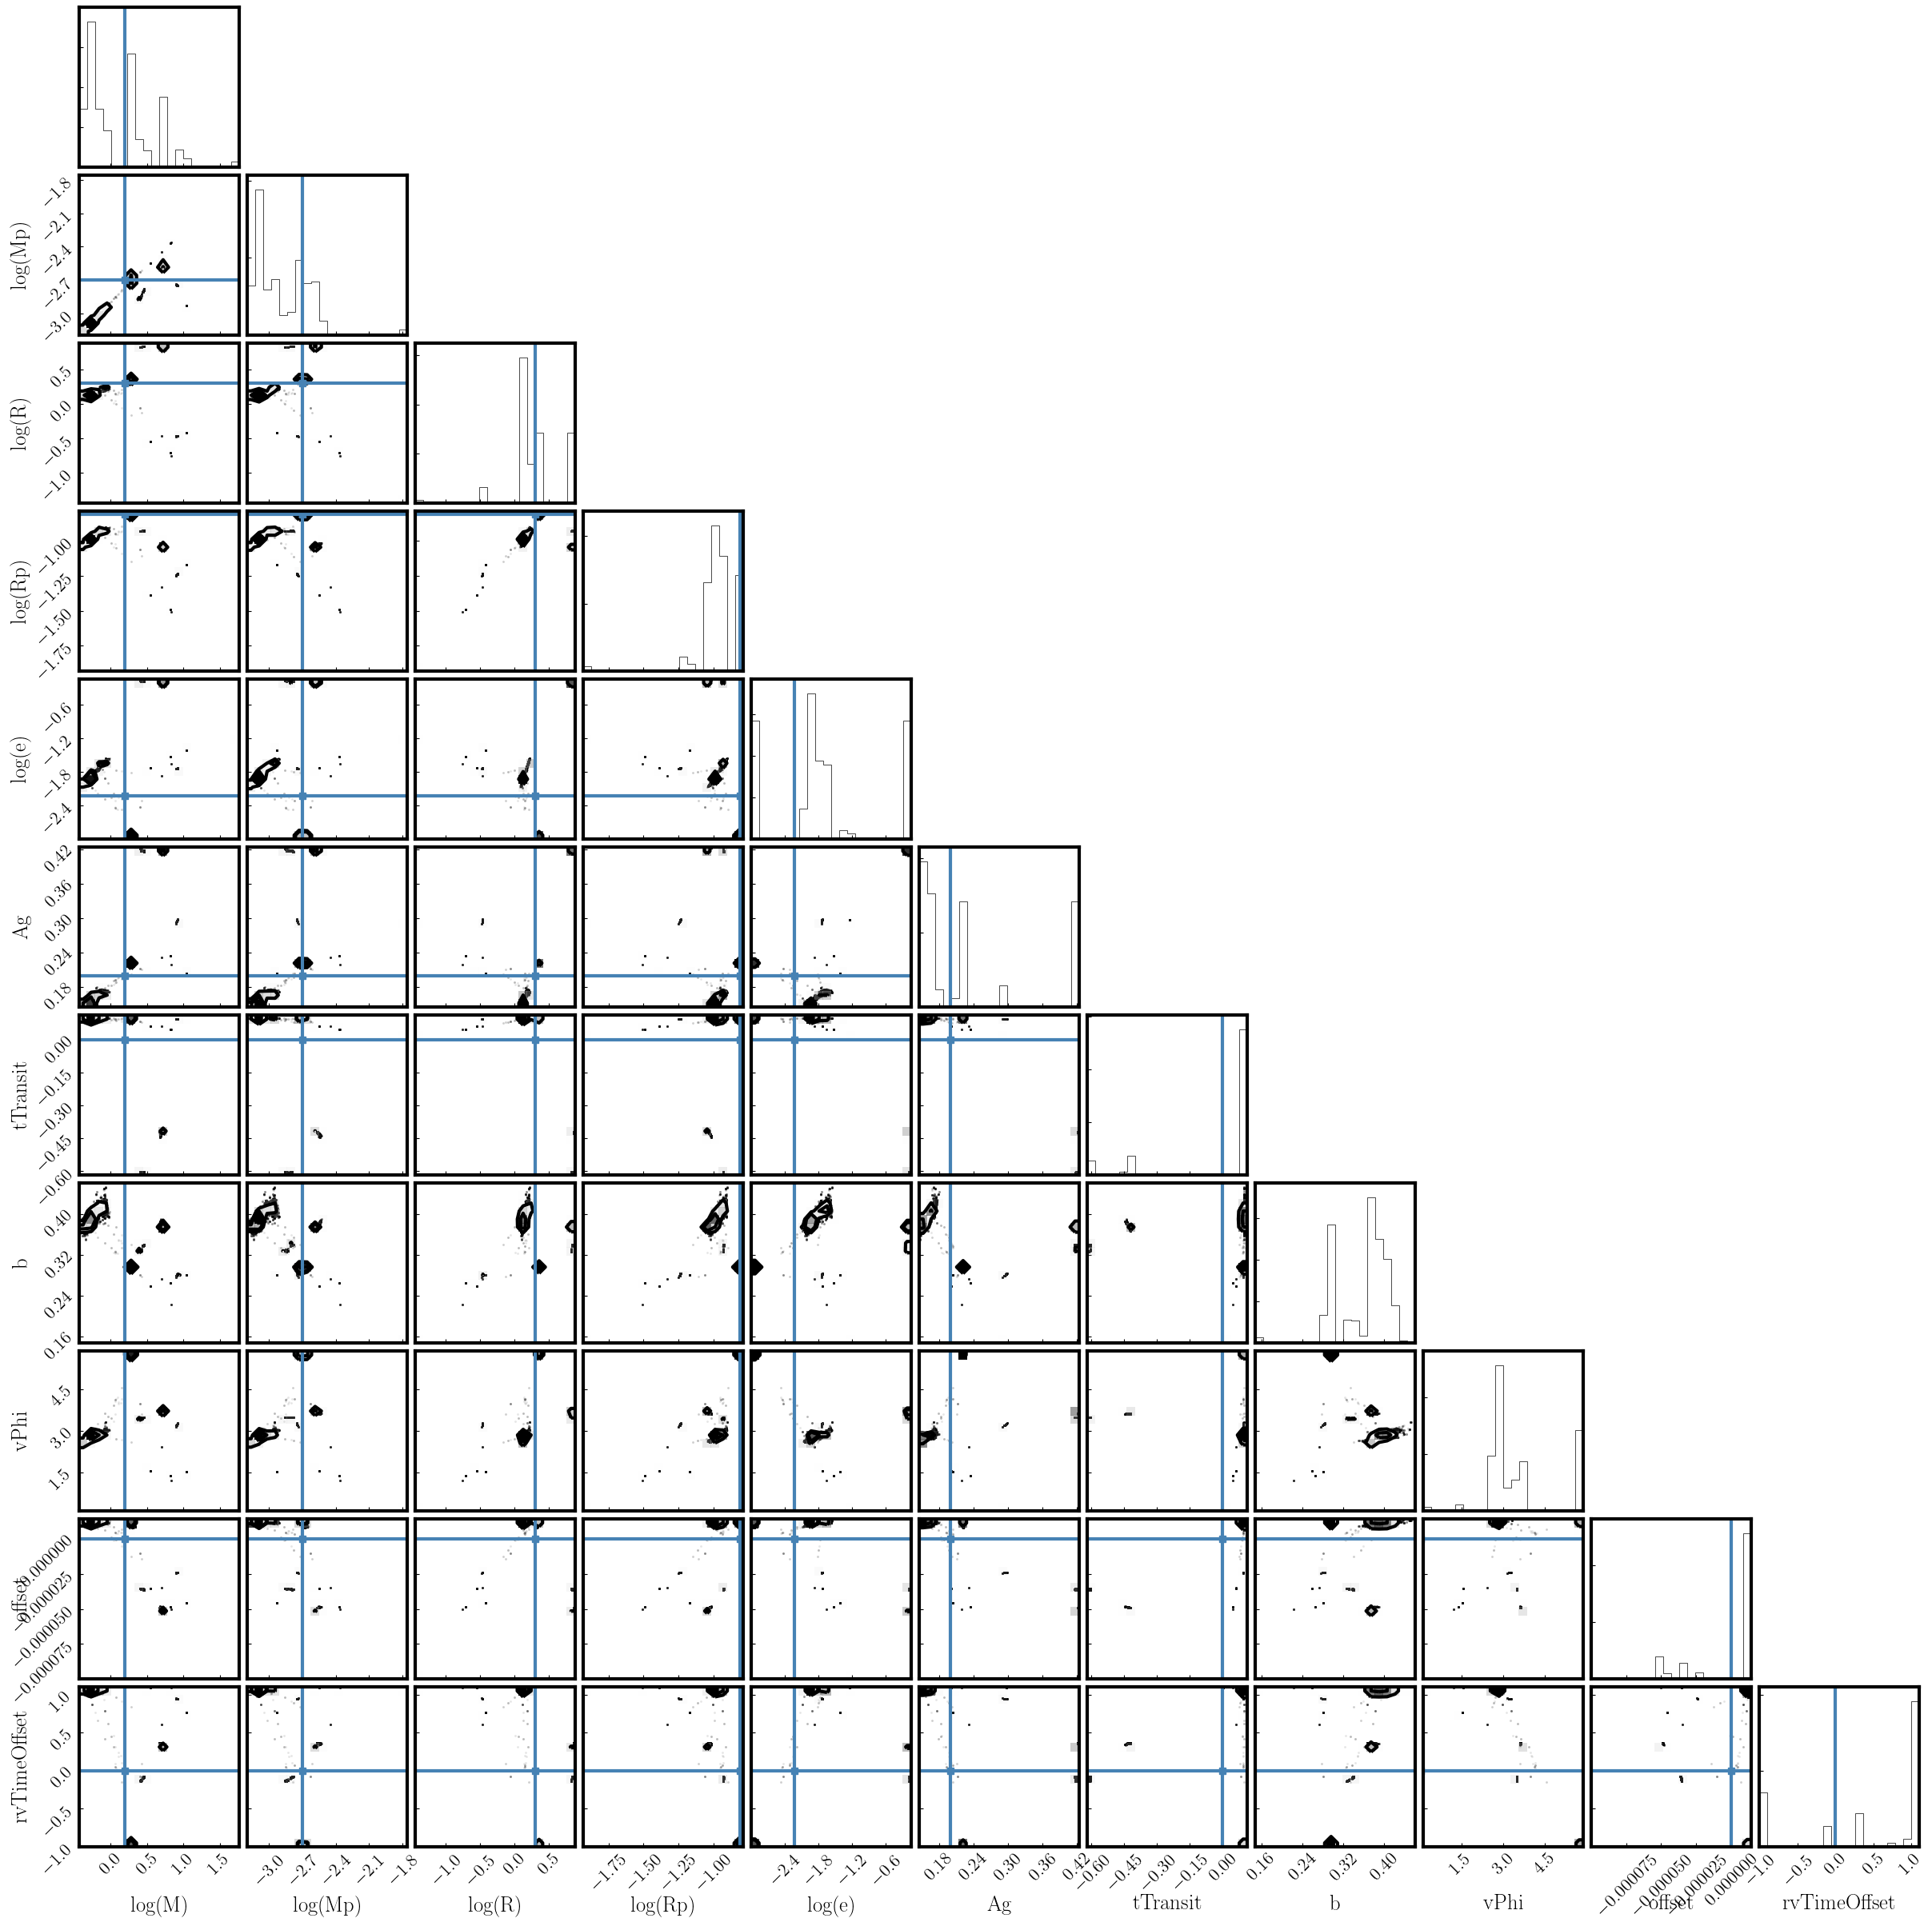

In [67]:
print(np.shape(sampler.chain))
samples = sampler.chain[:,1500:,:].reshape((-1, ndim))
truths=[np.log10(1.56),np.log10(0.002),np.log10(2),np.log10(0.155),np.log10(0.006),0.2,0,0.5,0,0,0]
mapped=mapXs(samples,period)
fig = corner.corner(mapped,labels=['log(M)','log(Mp)','log(R)','log(Rp)','log(e)','Ag','tTransit','b','vPhi','offset','rvTimeOffset'],truths=truths)
plt.show()

[ 2.72178144e-01 -2.69752482e+00  3.20320480e-01 -8.09214280e-01
 -2.99352806e+00  2.19873336e-01  9.92068431e-02  3.01494252e-01
  5.87144230e+00  1.01096381e-05 -1.00005990e+00]


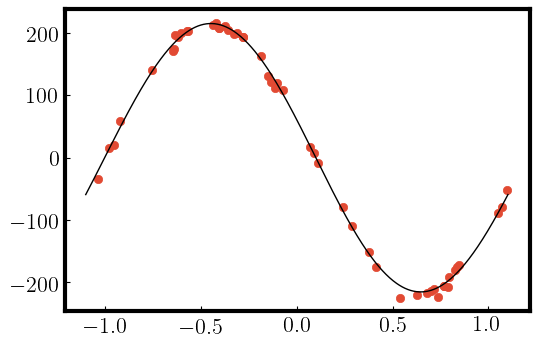

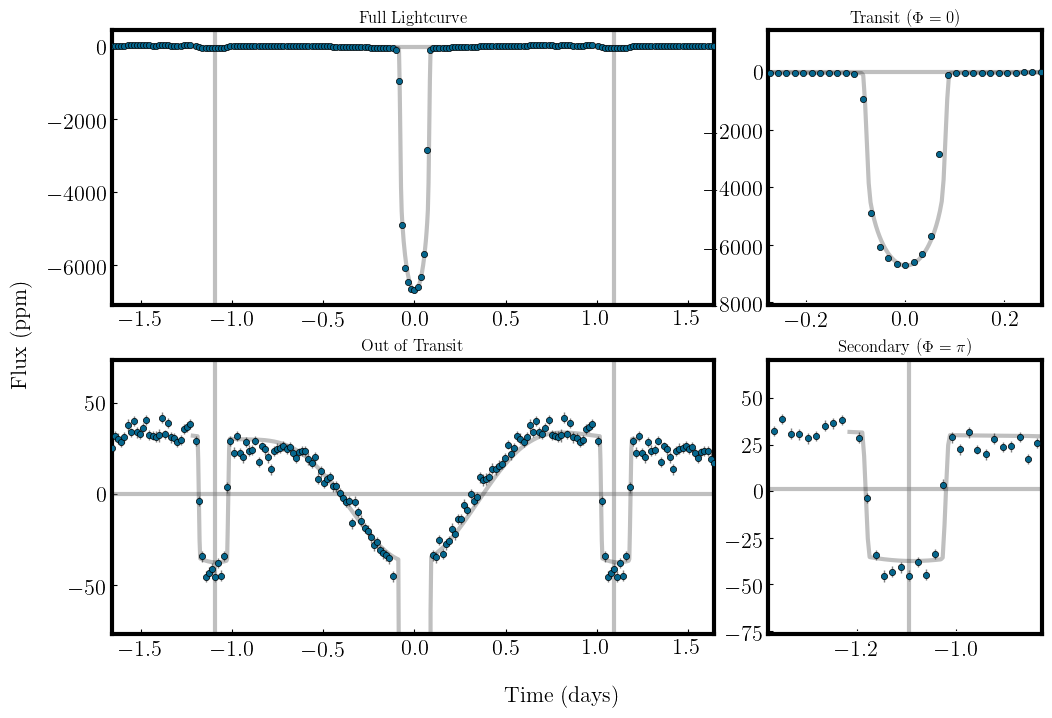

In [68]:
bestX=pos[np.argmax(prob),:]
print(mapXs(bestX,period))
planet=translateParams(planet,mapXs(bestX,period))
planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3)

nTs=600
modelTs=np.linspace(-period/2,period/2,nTs)
rvTs=((rTs+mapXs(bestX,period)[10])%period)-(period/2)

thisPlot=plt.gca()
thisPlot.scatter(rvTs,rVs)
modelRvs=oot.vSum(modelTs,planet)#*695508000/(24*60*2)
thisPlot.plot(modelTs,modelRvs,c='k',lw=1)
plt.show()

ootFs=1+oot.deltaSum(modelTs,planet)#,secondary=1)

transit=oot.checkTransit(planet)
if transit==1:
    t0,per,rp,a,inc,ecc,w=oot.batman(planet)
    params = batman.TransitParams()
    params.t0 = t0                       #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                     #planet radius (in units of stellar radii)
    params.a = a                       #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = ecc                      #eccentricity
    params.w = w                       #longitude of periastron (in degrees)
    params.u = [0.6]                #limb darkening coefficients
    params.limb_dark = "linear"       #limb darkening model

    m = batman.TransitModel(params, modelTs)
    batmanModel=m.light_curve(params)
    modelFs=ootFs*batmanModel
    norm=np.median(modelFs)
    
deltas=(modelFs/norm)-1
deltas=deltas+mapXs(bestX,period)[9]

thisFig,thisGrid=pyplot.makeFig()
pyplot.plotData(thisGrid,ts,fs,es,period=period)
pyplot.plotModel(thisGrid,modelTs,deltas,period=period)
plt.show()

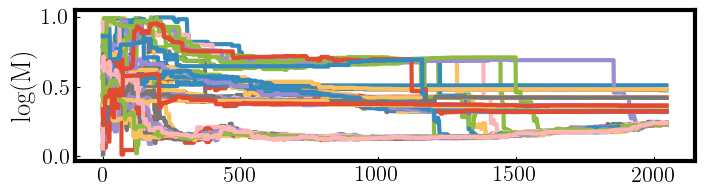

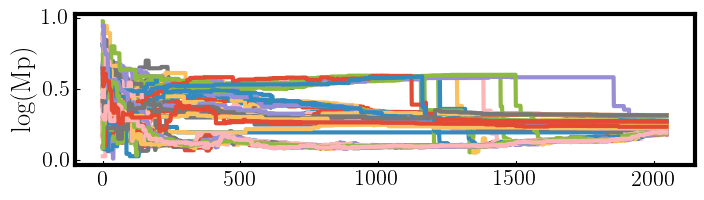

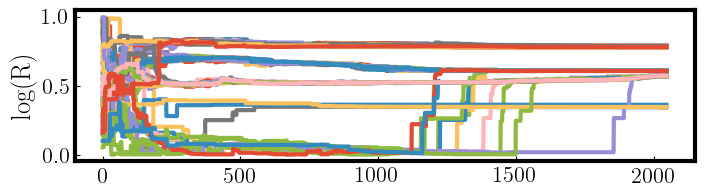

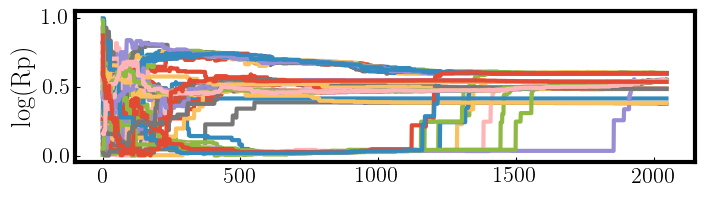

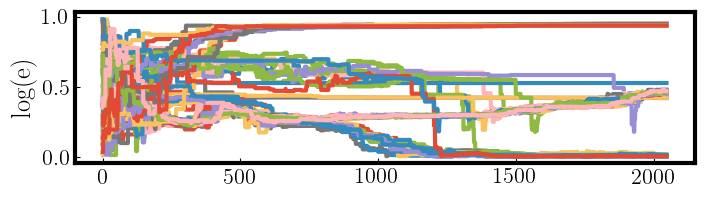

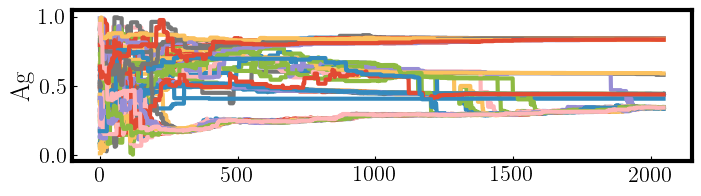

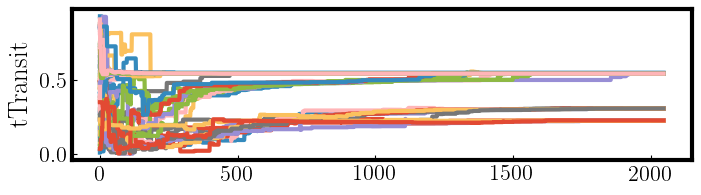

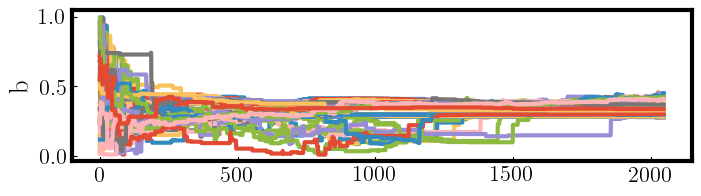

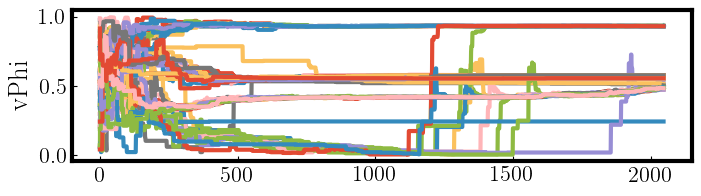

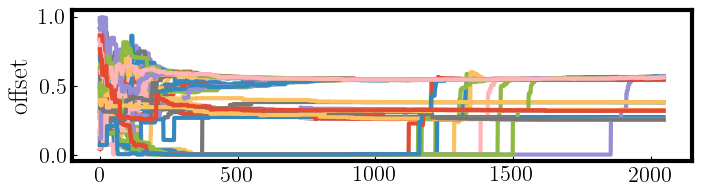

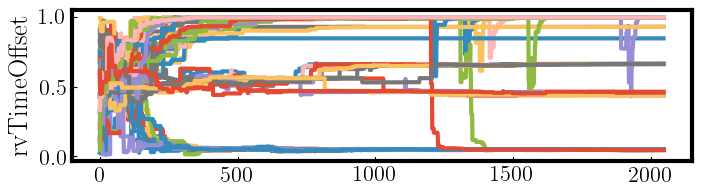

In [69]:
labels=['log(M)','log(Mp)','log(R)','log(Rp)','log(e)','Ag','tTransit','b','vPhi','offset','rvTimeOffset']

for i in range(11):
    fig = plt.figure(figsize=(8,2))
    for j in range(nwalkers):
        plt.plot(sampler.chain[j,:,i])
    
    plt.ylabel(labels[i])
    plt.show()